# Watch Different Instances of the Network Play Grid World

In [1]:
import gym
import numpy as np
import random
import tensorflow as tf
import matplotlib.pyplot as plt
import scipy.misc
import os
from IPython import display
import time
import math
%matplotlib inline

In [2]:
import numpy as np
import random
import itertools
import scipy.misc
import matplotlib.pyplot as plt


class gameOb():
    def __init__(self,coordinates,size,intensity,channel,reward,name):
        self.x = coordinates[0]
        self.y = coordinates[1]
        self.size = size
        self.intensity = intensity
        self.channel = channel
        self.reward = reward
        self.name = name
        
class gameEnv():
    def __init__(self,partial,size):
        self.sizeX = size
        self.sizeY = size
        self.actions = 4
        self.objects = []
        self.partial = partial
        self.a = self.reset()
#         plt.imshow(self.a,interpolation="nearest")
        
        
    def reset(self):
        self.objects = []
        hero = gameOb(self.newPosition(),1,1,2,None,'hero')
        self.objects.append(hero)
        bug = gameOb(self.newPosition(),1,1,1,10,'goal')
        self.objects.append(bug)
        hole = gameOb(self.newPosition(),1,1,0,-2,'fire')
        self.objects.append(hole)
#         bug2 = gameOb(self.newPosition(),1,1,1,10,'goal')
#         self.objects.append(bug2)
#         hole2 = gameOb(self.newPosition(),1,1,0,-2,'fire')
#         self.objects.append(hole2)
#         bug3 = gameOb(self.newPosition(),1,1,1,10,'goal')
#         self.objects.append(bug3)
#         bug4 = gameOb(self.newPosition(),1,1,1,10,'goal')
#         self.objects.append(bug4)
        self.a = self.renderEnv()
        return self.a

    def moveChar(self,direction):
        # 0 - up, 1 - down, 2 - left, 3 - right
        hero = self.objects[0]
        heroX = hero.x
        heroY = hero.y
        penalize = 0.00
        if direction == 0 and hero.y >= 1:
            hero.y -= 1
        if direction == 1 and hero.y <= self.sizeY-2:
            hero.y += 1
        if direction == 2 and hero.x >= 1:
            hero.x -= 1
        if direction == 3 and hero.x <= self.sizeX-2:
            hero.x += 1     
        if hero.x == heroX and hero.y == heroY:
            penalize = 1
        self.objects[0] = hero
        return penalize
    
    def newPosition(self):
        iterables = [ range(self.sizeX), range(self.sizeY)]
        points = []
        for t in itertools.product(*iterables):
            points.append(t)
        currentPositions = []
        for objectA in self.objects:
            if (objectA.x,objectA.y) not in currentPositions:
                currentPositions.append((objectA.x,objectA.y))
        for pos in currentPositions:
            points.remove(pos)
        location = np.random.choice(range(len(points)),replace=False)
        return points[location]

    def checkGoal(self):
        others = []
        for obj in self.objects:
            if obj.name == 'hero':
                hero = obj
            else:
                others.append(obj)
        ended = False
        for other in others:
            if hero.x == other.x and hero.y == other.y:
                self.objects.remove(other)
                if other.reward == 1:
                    self.objects.append(gameOb(self.newPosition(),1,1,1,10,'goal'))
                else: 
                    self.objects.append(gameOb(self.newPosition(),1,1,0,-2,'fire'))
                return other.reward,True
        if ended == False:
            return 0.0,False

    def renderEnv(self):
        #a = np.zeros([self.sizeY,self.sizeX,3])
        self.a = np.ones([self.sizeY+2,self.sizeX+2,3])
        self.a[1:-1,1:-1,:] = 0
        hero = None
        for item in self.objects:
            self.a[item.y+1:item.y+item.size+1,item.x+1:item.x+item.size+1,item.channel] = item.intensity
            if item.name == 'hero':
                hero = item
        if self.partial == True:
            self.a = self.a[hero.y:hero.y+3,hero.x:hero.x+3,:]
        b = scipy.misc.imresize(self.a[:,:,0],[84,84,1],interp='nearest')
        c = scipy.misc.imresize(self.a[:,:,1],[84,84,1],interp='nearest')
        d = scipy.misc.imresize(self.a[:,:,2],[84,84,1],interp='nearest')
        self.a = np.stack([b,c,d],axis=2)
        return self.a

    def step(self,action):
        penalty = self.moveChar(action)
        reward,done = self.checkGoal()
        if(penalty != 0):
            done = True
        state = self.renderEnv()
        return state,(reward-penalty),done

In [3]:
class Qnetwork():
    def __init__(self,h_size,prev_states):
        dimensions = [1, 84, 84, 3]
        self.image_to_resize = tf.placeholder(shape=dimensions, dtype=tf.float32,name='image_to_resize')
        self.y = tf.identity(self.image_to_resize)
        self.resized_image = tf.image.resize_images(self.y, dimensions[1], dimensions[2])
        
        #The network recieves a frame from the game, flattened into an array.
        #It then resizes it and processes it through four convolutional layers.
        self.imageIn = tf.placeholder(shape=[None,84,84,3],dtype=tf.float32)
        self.conv1 = tf.contrib.layers.convolution2d( \
            inputs=self.imageIn,num_outputs=32,kernel_size=[8,8],stride=[4,4],padding='VALID', biases_initializer=None)
        self.conv2 = tf.contrib.layers.convolution2d( \
            inputs=self.conv1,num_outputs=64,kernel_size=[4,4],stride=[2,2],padding='VALID', biases_initializer=None)
        self.conv3 = tf.contrib.layers.convolution2d( \
            inputs=self.conv2,num_outputs=64,kernel_size=[3,3],stride=[1,1],padding='VALID', biases_initializer=None)
        self.conv4 = tf.contrib.layers.convolution2d( \
            inputs=self.conv3,num_outputs=512,kernel_size=[7,7],stride=[1,1],padding='VALID', biases_initializer=None)
        
        #We take the output from the final convolutional layer and split it into separate advantage and value streams.
        self.streamAC,self.streamVC = tf.split(3,2,self.conv4)
        self.streamA = tf.contrib.layers.flatten(self.streamAC)
        self.streamV = tf.contrib.layers.flatten(self.streamVC)
        self.AW = tf.Variable(tf.random_normal([h_size//2,env.actions]))
        self.VW = tf.Variable(tf.random_normal([h_size//2,1]))
        self.Advantage = tf.matmul(self.streamA,self.AW)
        self.Value = tf.matmul(self.streamV,self.VW)
        
        #Then combine them together to get our final Q-values.
        self.Qout = self.Value + tf.sub(self.Advantage,tf.reduce_mean(self.Advantage,reduction_indices=1,keep_dims=True))
        self.predict = tf.argmax(self.Qout,1)
        
        #Below we obtain the loss by taking the sum of squares difference between the target and prediction Q values.
        self.targetQ = tf.placeholder(shape=[None],dtype=tf.float32)
        self.actions = tf.placeholder(shape=[None],dtype=tf.int32)
        self.actions_onehot = tf.one_hot(self.actions,env.actions,dtype=tf.float32)
        
        self.Q = tf.reduce_sum(tf.mul(self.Qout, self.actions_onehot), reduction_indices=1)
        
        self.td_error = tf.square(self.targetQ - self.Q)
        self.loss = tf.reduce_mean(self.td_error)
        self.trainer = tf.train.AdamOptimizer(learning_rate=0.0001)
        self.updateModel = self.trainer.minimize(self.loss)

#### Watch random network perform horribly at gridworld

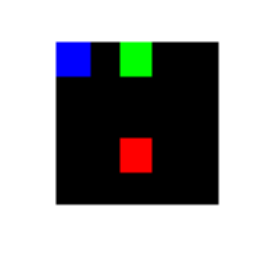

KeyboardInterrupt: 

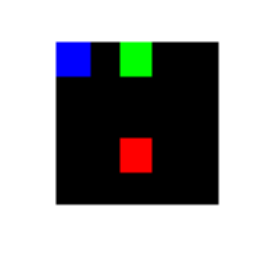

In [15]:
# tf.reset_default_graph()
env = gameEnv(partial=False,size=5)
# mainQN = Qnetwork(512,1)
# targetQN = Qnetwork(512,1)
# init = tf.initialize_all_variables()
arr = []
with tf.Session() as sess:
#     saver = tf.train.Saver()
#     load = './dqn/save_data/gridWorld/one_go1/model-40000.cptk'
#     saver.restore(sess, load)
    for i in range(20):
        complete = False
        iter = 0
        env = gameEnv(partial=False,size=5)
        plt.imshow(env.a)
        r_all = 0
        while(complete == False):
            action = np.random.randint(0, 4)
            observation, reward, done = env.step(action)
            plt.imshow(env.a)
            plt.axis('off')
            display.clear_output(wait=True)
            display.display(plt.gcf())
            r_all += reward
            if(iter > 20):
                done = True
            iter += 1
            if(done):
                arr.append(r_all)
                complete = True
                print(iter)
                print("Complete")
                print("reward: ", r_all)
            time.sleep(2)
#             plt.show()
        print("\n \n \n")

#### Watch network play gridworld and succeed ~70% of the time

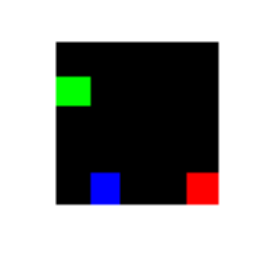

KeyboardInterrupt: 

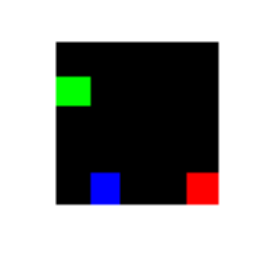

In [10]:
tf.reset_default_graph()
env = gameEnv(partial=False,size=5)
mainQN = Qnetwork(512,1)
targetQN = Qnetwork(512,1)
init = tf.initialize_all_variables()
arr = []
with tf.Session() as sess:
    saver = tf.train.Saver()
    load = './dqn/save_data/gridWorld/one_go1/model-40000.cptk'
    saver.restore(sess, load)
    for i in range(20):
        complete = False
        iter = 0
        env = gameEnv(partial=False,size=5)
        plt.imshow(env.a)
        r_all = 0
        while(complete == False):
            action = sess.run(mainQN.predict, feed_dict={mainQN.imageIn:[env.a]})
            observation, reward, done = env.step(action)
            plt.imshow(env.a)
            plt.axis('off')
            display.clear_output(wait=True)
            display.display(plt.gcf())
            r_all += reward
            if(iter > 20):
                done = True
            iter += 1
            if(done):
                arr.append(r_all)
                complete = True
                print(iter)
                print("Complete")
                print("reward: ", r_all)
            time.sleep(2)
#             plt.show()
        print("\n \n \n")

#### Watch network at peak performance ~90%

KeyboardInterrupt: 

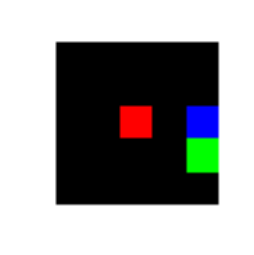

In [13]:
tf.reset_default_graph()
env = gameEnv(partial=False,size=5)
mainQN = Qnetwork(512,1)
targetQN = Qnetwork(512,1)
init = tf.initialize_all_variables()
arr = []
with tf.Session() as sess:
    saver = tf.train.Saver()
    load = './dqn/save_data/gridWorld/one_go_random/model-50000.cptk'
    saver.restore(sess, load)
    for i in range(20):
        complete = False
        iter = 0
        env = gameEnv(partial=False,size=5)
        plt.imshow(env.a)
        r_all = 0
        while(complete == False):
            action = sess.run(mainQN.predict, feed_dict={mainQN.imageIn:[env.a]})
            observation, reward, done = env.step(action)
            plt.imshow(env.a)
            plt.axis('off')
            display.clear_output(wait=True)
            display.display(plt.gcf())
            r_all += reward
            if(iter > 20):
                done = True
            iter += 1
            if(done):
                arr.append(r_all)
                complete = True
                print(iter)
                print("Complete")
                print("reward: ", r_all)
            time.sleep(2)
#             plt.show()
        print("\n \n \n")